# Biotuner Paper Design and Implementation Examples

In [1]:
from biotuner.biotuner_object import *
from biotuner.metrics import *
import pandas as pd
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from neurodsp.sim import sim_combined
from scipy.interpolate import make_interp_spline, BSpline
from biotuner.biotuner_utils import generate_signal
from biotuner.biotuner_object import compute_biotuner
import numpy as np

### Figure 2. Comparative analysis of different metrics evaluated across frequency pairs from unison to octave. 

In [2]:
# Generate all pairs of values with 0.1 precision between 1 and 10
values = np.arange(5, 10.1, 0.1)
pairs = [(round(x, 1), round(y, 1)) for x in values for y in values if x != y]
cons_tot = []
tenney_tot = []
harmsim_tot = []
subharm_tension_tot = []
subharm_tension2_tot = []
euler_tot = []
int_tenney_tot = []
for peaks in pairs:
    peaks = list(peaks)
    peaks_ratios = compute_peak_ratios(
            peaks, rebound=True, octave=2, sub=False
        )
    a, b, c, cons = consonance_peaks(peaks, 0.1)
    tenney = tenneyHeight(peaks)
    int_tenney = integral_tenneyHeight(peaks)
    harmsim = np.average(ratios2harmsim(peaks_ratios))
    _, _, subharm, _ = compute_subharmonic_tension(peaks,
                                                       5,
                                                       50,
                                                       min_notes=2)
    _, _, subharm2, _ = compute_subharmonic_tension(peaks,
                                                        20,
                                                        50,
                                                        min_notes=2)
    subharm_tension = subharm[0]
    peaks_euler = [int(round(num, 2) * 1000) for num in peaks]
    euler_ = euler(*peaks_euler)
    cons_tot.append(cons)
    tenney_tot.append(tenney)
    harmsim_tot.append(harmsim)
    subharm_tension_tot.append(subharm_tension)
    subharm_tension2_tot.append(subharm2[0])
    int_tenney_tot.append(int_tenney)
    #print('SUBHARM TENSION: ', subharm2[0])
    euler_tot.append(euler_)
    
# create a dataframe with all the values
df = pd.DataFrame({'cons': cons_tot,
                   'tenney': tenney_tot,
                   'int_tenney': int_tenney_tot, # 'int_tenney': int_tenney_tot,
                   'harmsim': harmsim_tot,
                   'subharm_tension': subharm_tension_tot,
                   'subharm_tension2': subharm_tension2_tot,
                   'euler': euler_tot,
                   'freq_pairs': pairs})

c:\users\antoine\github\biotuner\biotuner\metrics.py:946: RuntimeWarning: divide by zero encountered in scalar divide
  harm_temp.append(1 / delta_norm)
c:\Users\Antoine\anaconda3\envs\biotuner\Lib\site-packages\numpy\lib\_function_base_impl.py:557: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\Antoine\anaconda3\envs\biotuner\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


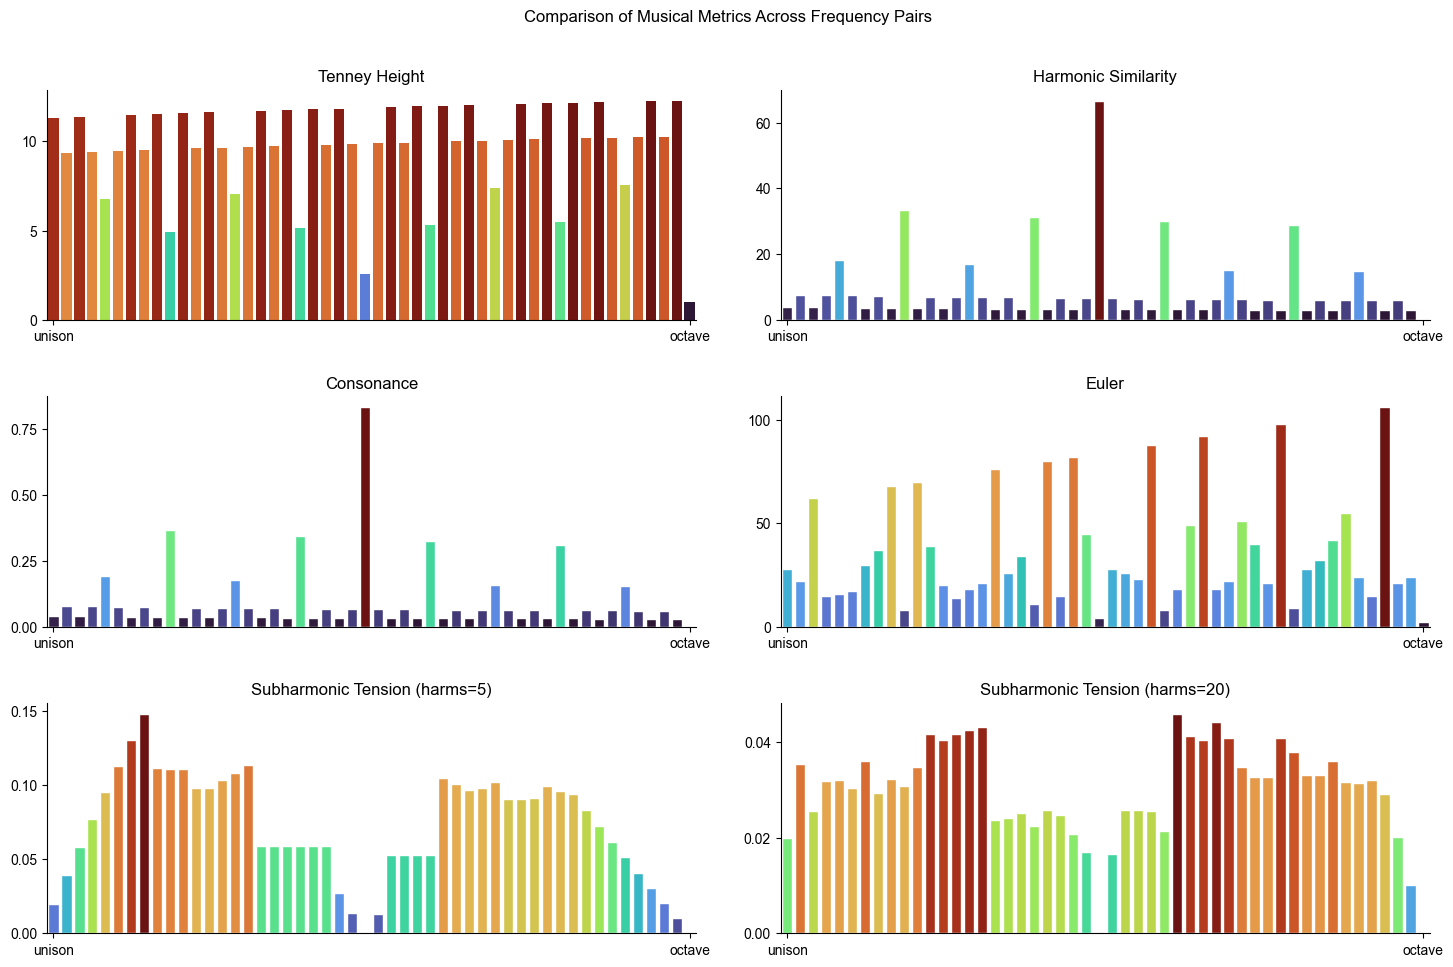

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# remove warnings
import warnings
warnings.filterwarnings("ignore")

# Assuming 'data' is a DataFrame with the required columns
data = df.copy()

# Ensure 'freq_pairs' is a single-level index and of type string
if isinstance(data.index, pd.MultiIndex):
    data = data.reset_index()

data['freq_pairs'] = data['freq_pairs'].astype(str)

# Drop NaN values in 'freq_pairs' or other columns
data = data.dropna(subset=['freq_pairs'])

# Take the first 50 pairs for simplicity
data = data.iloc[:50]

# Set up the plots
fig, axs = plt.subplots(3, 2, figsize=(15, 10))  # Adjust size as needed
fig.suptitle('Comparison of Musical Metrics Across Frequency Pairs')

# Create a colormap for consistent gradient
cmap = sns.color_palette("turbo", as_cmap=True)

# Normalize data for color scaling
def get_colors(values):
    norm = plt.Normalize(np.min(values), np.max(values))
    return [cmap(norm(v)) for v in values]

# Plotting each metric with gradient colors
metrics = ['tenney', 'harmsim', 'cons', 'euler', 'subharm_tension', 'subharm_tension2']
titles = [
    'Tenney Height',
    'Harmonic Similarity',
    'Consonance',
    'Euler',
    'Subharmonic Tension (harms=5)',
    'Subharmonic Tension (harms=20)'
]

for ax, metric, title in zip(axs.flat, metrics, titles):
    colors = get_colors(data[metric])  # Generate colors based on metric values
    sns.barplot(x='freq_pairs', y=metric, data=data, ax=ax, palette=colors)
    ax.set_title(title)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(axis='x', rotation=0)
    ax.set_xticks([0, len(data) - 1])
    ax.set_xticklabels(['unison', 'octave'])
    sns.set_style("white")
    sns.despine()

sns.set(font_scale=1.8)
sns.set_style("white")
plt.tight_layout()

# Save figure
plt.savefig('metrics_comparison_fixed_gradient.png', dpi=300)
plt.show()


### Figure 3 (pairs). Correlation Matrix for sets of 2 peaks

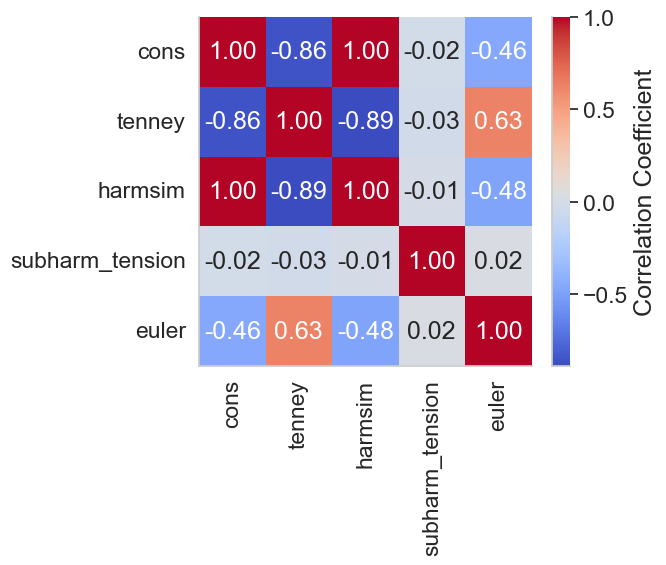

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt


# remove frequency pairs
df = df.drop(['freq_pairs'], axis=1)
# Compute the correlation matrix
corr = df.corr()

# Round the values for readability
corr = corr.round(2)
import seaborn as sns
import matplotlib.pyplot as plt

# Drop specific rows and columns
corr = corr.drop(['int_tenney', 'subharm_tension2'], axis=0, errors="ignore")
corr = corr.drop(['int_tenney', 'subharm_tension2'], axis=1, errors="ignore")

# Ensure no duplicates and correct data type
corr = corr.loc[~corr.index.duplicated(), ~corr.columns.duplicated()]
corr = corr.astype(float)

# Plot heatmap
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
plt.figure(figsize=(7, 6))
sns.heatmap(
    corr,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    xticklabels=True,
    yticklabels=True,
    cbar_kws={"label": "Correlation Coefficient"}
)
sns.despine()
plt.tight_layout()
plt.savefig("correlation_matrix_pairs.png", dpi=300)
plt.show()


### Figure 3 (triplets). Correlation Matrix for sets of 3 peaks

In [5]:
import random
# Generate all triplets of values with 0.1 precision between 1 and 10
values = np.arange(1, 10, 0.1)
triplets = [(round(x, 1), round(y, 1), round(z, 1)) for x in values for y in values for z in values if x != y and y != z and x != z]
# select 8190 triplets randomly
triplets = random.sample(triplets, 100)
cons_tot = []
tenney_tot = []
harmsim_tot = []
subharm_tension_tot = []
euler_tot = []
for peaks in triplets:
    peaks = list(peaks)
    peaks_ratios = compute_peak_ratios(
            peaks, rebound=True, octave=2, sub=False
        )
    a, b, c, cons = consonance_peaks(peaks, 0.1)
    tenney = tenneyHeight(peaks)
    harmsim = np.average(ratios2harmsim(peaks_ratios))
    _, _, subharm, _ = compute_subharmonic_tension(peaks,
                                                       10,
                                                       200,
                                                       min_notes=2)
    subharm_tension = subharm[0]
    peaks_euler = [int(round(num, 2) * 1000) for num in peaks]
    euler_ = euler(*peaks_euler)
    cons_tot.append(cons)
    tenney_tot.append(tenney)
    harmsim_tot.append(harmsim)
    subharm_tension_tot.append(subharm_tension)
    euler_tot.append(euler_)
    
# create a dataframe with all the values
df2 = pd.DataFrame({'cons': cons_tot,
                   'tenney': tenney_tot,
                   'harmsim': harmsim_tot,
                   'subharm_tension': subharm_tension_tot,
                   'euler': euler_tot})

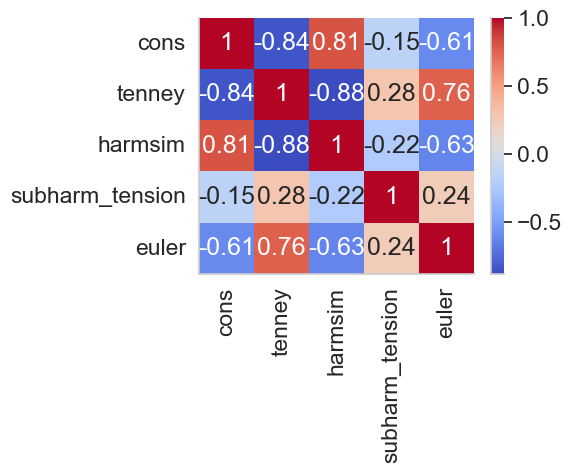

In [6]:
# print correlation matrix using seaborn
import seaborn as sns
# list symetric cmap
cmap = ['RdBu_r', 'coolwarm', 'bwr', 'seismic']
corr = df2.corr()
plt.figure(figsize=(6, 5))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            annot=True, cmap='coolwarm')
# make text bigger
sns.set(font_scale=1.3)

# make the plot style nicer
sns.set_style("whitegrid")
plt.tight_layout()
sns.despine()
plt.savefig('correlation_matrix_triplets.png', dpi=300)
plt.show()

### Figure 4. Time-Resolved Harmonicity using instantaneous frequencies for three different types of signals

(4, 1800)
(4, 1800)
(4, 1800)
Dyad similarity:  (3, 1800)


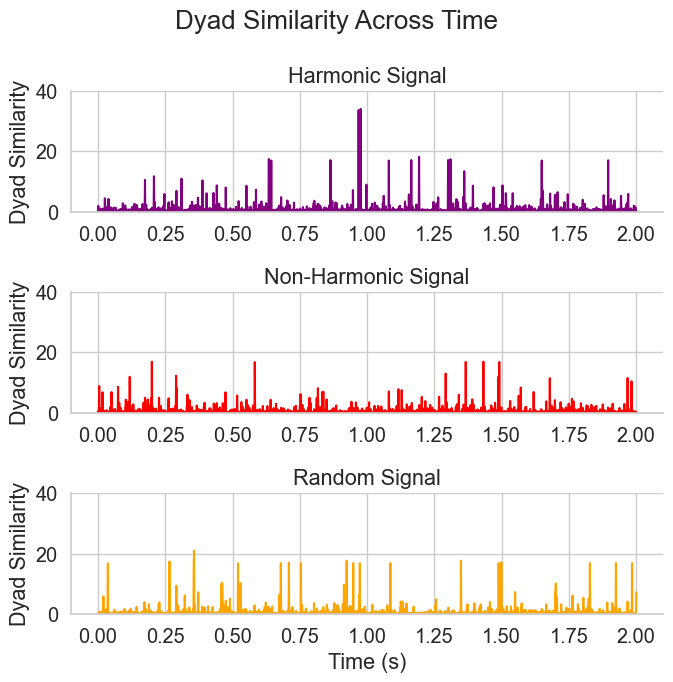

In [7]:
from biotuner.biotuner_object import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from PyEMD import EMD
from fractions import Fraction
from biotuner.metrics import dyad_similarity
import seaborn as sns

def simulate_harmonic_signal(frequencies, amplitudes, duration, sampling_rate):
    time = np.linspace(0, duration, int(sampling_rate * duration))
    signal = np.sum([amp * np.sin(2 * np.pi * freq * time) for freq, amp in zip(frequencies, amplitudes)], axis=0)
    return time, signal

# Simulate a signal
sampling_rate = 1000  # in Hz
duration = 2  # in seconds
frequencies = [10, 15, 20]  # in Hz
amplitudes = [1, 0.5, 0.2]

time, signal = simulate_harmonic_signal(frequencies, amplitudes, duration, sampling_rate)

time, signal2 = simulate_harmonic_signal([10, 15.7, 21.9], [1, 0.5, 0.2], duration, sampling_rate)


# create random signal
signal3 = np.random.rand(len(time))

signals = [signal, signal2, signal3]

dyad_sim_tot = []
dyad_sim_tot = []
IFs = []
chords_all = []
chords_pos_all = []
for sig in signals:
    bt = compute_biotuner(data=sig, sf=sampling_rate, peaks_function='EMD_fast')
    tr_harm, chords, chords_pos = bt.time_resolved_harmonicity(nIMFs=3, input='SpectralCentroid', window=50, keep_first_IMF=True, graph=False, limit_cons=15, min_notes=3)
    IFs.append(bt.spectro_EMD)
    chords_all.append(chords)
    chords_pos_all.append(chords_pos)
    dyad_sim_tot.append(tr_harm)


print('Dyad similarity: ', np.array(dyad_sim_tot).shape)
colors = ['purple', 'red', 'orange']
# create a figure with 3 subplots
fig, axs = plt.subplots(3, 1, figsize=(7, 7))  # Adjust size as needed
fig.suptitle('Dyad Similarity Across Time')
# set white background
sns.set_style("white")
# use dyad_sim_tot to derive time
time = np.linspace(0, duration, len(dyad_sim_tot[0]))
# Plotting each metric in a separate subplot
axs[0].plot(time, dyad_sim_tot[0], color=colors[0])
axs[0].set_title('Harmonic Signal')
axs[1].plot(time, dyad_sim_tot[1], color=colors[1])
axs[1].set_title('Non-Harmonic Signal')
axs[2].plot(time, dyad_sim_tot[2], color=colors[2])
axs[2].set_title('Random Signal')
#axs[0].set_yscale('log')
#axs[1].set_yscale('log')
#axs[2].set_yscale('log')
# Formatting
for ax in axs.flat:
    # remove xlabel
    ax.set_ylabel('Dyad Similarity')
    ax.tick_params(axis='x')  # Rotate x-axis labels for readability
    # set ylim to 0-35
    ax.set_ylim([0, 40])
    # make the plot style nicer
    sns.set_style("whitegrid")
    sns.despine()
    # log y-axis
# set x-axis title only for the last subplot
axs[2].set_xlabel('Time (s)')
    

plt.tight_layout()
plt.show()
#plt.savefig('time_resolved_example_centroid.png', dpi=300)

### Figure 5. Identification of spectral chords using time-resolved harmonicity

<Figure size 640x480 with 0 Axes>

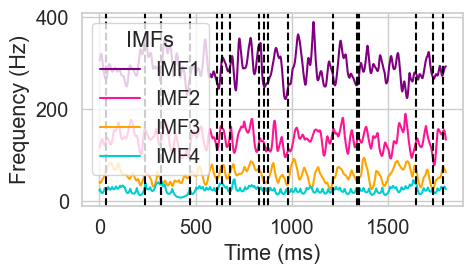

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming IFs, chords_pos_all, and chords_all are defined elsewhere in your code

final_IFs = IFs[-1]
final_chord_pos = chords_pos_all[-1]
final_chords = chords_all[-1]

# plot final IFs with seaborn lineplot
sns.set_style("whitegrid")
sns.despine()
plt.figure(figsize=(5, 3))

# Swap axes
final_IFs = final_IFs.T

# Define colors
colors = ['purple', 'deeppink', 'orange', 'darkturquoise']

# Create line plot with different colors for each line but same linestyle
ax = sns.lineplot(data=final_IFs, dashes=False, palette=colors, linewidth=1.5)

# Set axis labels
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (Hz)')

# Add vertical lines for chord positions (which are indexes of the IFs)
for pos in final_chord_pos:
    plt.axvline(x=pos, color='black', linestyle='--')

# Get the lines from the axes to create custom handles for the legend
lines = ax.get_lines()

# Create custom handles for the legend
custom_handles = [lines[i] for i in range(4)]

# Create custom labels for the legend
custom_labels = ['IMF1', 'IMF2', 'IMF3', 'IMF4']

# Set the legend with custom handles and labels
plt.legend(handles=custom_handles, labels=custom_labels, title='IMFs', loc='upper left')

plt.tight_layout()
#plt.savefig('spectro_EMD_example.png', dpi=300)
plt.show()


In [9]:
import numpy as np

# Frequency to note mapping
A4 = 440
C0 = A4 * np.power(2, -4.75)
note_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']

def freq_to_note(frequency):
    """ Convert a frequency to a musical note name. """
    h = round(12 * np.log2(frequency / C0))
    octave = h // 12
    n = h % 12
    return note_names[n] + str(octave)

# Your sets of frequencies
freq_sets = final_chords
# shift all freqs by factor 4
freq_sets = [[x*8 for x in freq] for freq in freq_sets]

# Convert each set of frequencies to notes
chords = []
for freq_set in freq_sets:
    chord = [freq_to_note(f) for f in freq_set]
    chords.append(chord)

print("Chords (in note names):")
for i, chord in enumerate(chords):
    print(f"Chord {i + 1}: {', '.join(chord)}")


# convert note from Hz to MIDI
def freq_to_midi(frequency):
    """ Convert a frequency to a MIDI note number. """
    return 69 + 12 * np.log2(frequency / A4)

# Your sets of frequencies
MIDI_set = []
for freq_set in freq_sets:
    MIDI_set.append([freq_to_midi(f) for f in freq_set])
    
# generate a simple MIDI file with the chords
from mido import Message, MidiFile, MidiTrack

mid = MidiFile()
track = MidiTrack()
mid.tracks.append(track)

# Add a track name and tempo. The first argument to Message is the MIDI event type, and the remaining arguments are data.
track.append(Message('program_change', program=12, time=0))

# Add notes. The first argument is the MIDI note number, and the second argument is the note duration in beats.
for chord in MIDI_set:
    for note in chord:
        track.append(Message('note_on', note=int(note), velocity=100, time=0))
    for note in chord:
        track.append(Message('note_off', note=int(note), velocity=100, time=100))
        
# Save the MIDI file
mid.save('example.mid')

Chords (in note names):
Chord 1: G#3, C5, C6, C7
Chord 2: E4, A4, D#6, F#7
Chord 3: D4, F4, C6, C7
Chord 4: D#4, E4, C#6, C#7
Chord 5: G#3, A4, A5, C7
Chord 6: G3, G4, A5, C7
Chord 7: D#4, D#5, D#6, D#7
Chord 8: E3, C5, D6, D7
Chord 9: A3, C#5, C#6, F7
Chord 10: F3, F4, C6, B6
Chord 11: F3, F#4, A#5, C7
Chord 12: D#3, D4, A5, B6
Chord 13: A3, G4, D#6, C#7
Chord 14: F3, F4, C6, B6
Chord 15: G3, G4, C#6, C#7
Chord 16: D#4, D5, C6, C#7
Chord 17: G#3, G#3, G5, C#7
Chord 18: A#3, D#5, D#6, C#7


### Figure 6. Comparison of Normalized Dissonance and Harmonic Entropy Across Different Sets of Harmonics. 

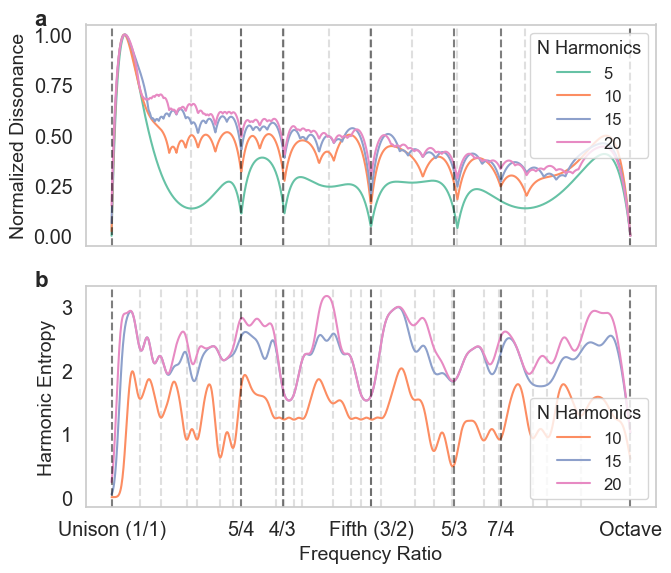

In [10]:
# Assuming the functions diss_curve and harmonic_entropy are pre-defined and accessible
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from biotuner.scale_construction import diss_curve, harmonic_entropy
from biotuner.biotuner_utils import compute_peak_ratios, ratios_increments
from biotuner.peaks_extension import harmonic_fit
from biotuner.vizs import plot_diss_curve, plot_harm_entropy
from scipy.signal import argrelextrema
from fractions import Fraction
# Set the style of seaborn
sns.set_style("whitegrid")

peaks_dict = {
    '5': [1, 2, 3, 4, 5],
    '10': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    '15': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,11,12,13,14,15],
    '20': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,11,12,13,14,15,16, 17, 18, 19, 20],
}
# Create subplots with shared x-axis
fig, axs = plt.subplots(2, 1, figsize=(7, 6), sharex=True)
colors = sns.color_palette("Set2", n_colors=len(peaks_dict.keys()))
# Plotting the dissonance curves for each dictionary
plot_diss_curve(peaks_dict, colors=colors, ax = axs[0])
HE_scale = plot_harm_entropy(peaks_dict, colors=colors, ax=axs[1])
# add letter a and b to the subplots
axs[0].text(-0.09, 1.07, 'a', transform=axs[0].transAxes, fontsize=16, fontweight='bold', va='top')
axs[1].text(-0.09, 1.07, 'b', transform=axs[1].transAxes, fontsize=16, fontweight='bold', va='top')

axs[-1].set_xlabel('Frequency Ratio', fontsize=14)
# replace xticks with ratios names
ticks = [1, 1.25, 1.33, 1.5, 1.66, 1.75, 2]
axs[-1].set_xticks(ticks)
# add black vertical lines for the ratios
for ratio in ticks:
    axs[0].axvline(ratio, color='black', linestyle='--', linewidth=1.5, alpha=0.5)
    axs[1].axvline(ratio, color='black', linestyle='--', linewidth=1.5, alpha=0.5)
axs[-1].set_xticklabels(['Unison (1/1)', '5/4','4/3', 'Fifth (3/2)', '5/3', '7/4', 'Octave'])
# remove horizontal grid lines only
axs[0].grid(axis='y')
axs[1].grid(axis='y')
# remove vertical grid lines
axs[0].grid(axis='x')
axs[1].grid(axis='x')


plt.tight_layout()
#plt.savefig('dissonance_curves_harmonic_entropyX.png', dpi=300)
plt.show()

### Figure 8. Visualization of Euclidean rhythms with varying maximal denominators

[ 9.5 17.  19.1]


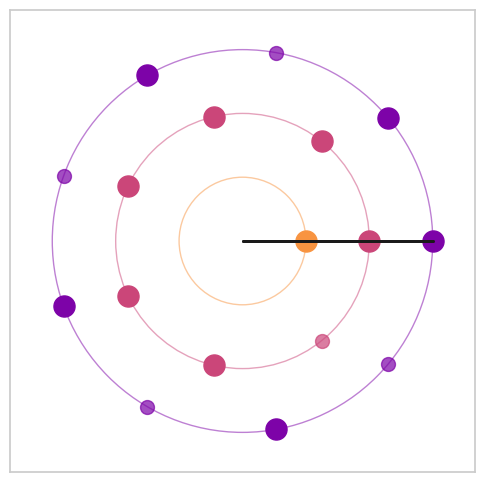

[ 9.5 17.  19.1]


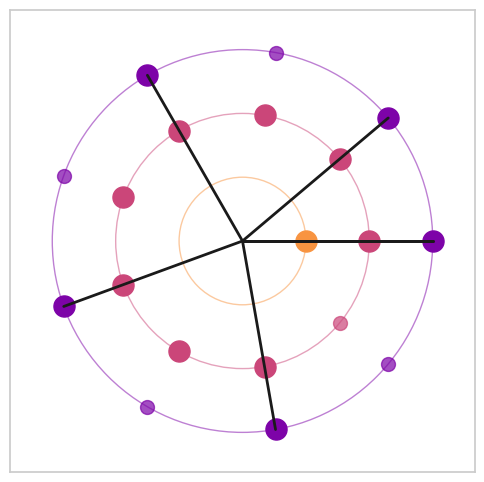

[ 9.5 17.  19.1]


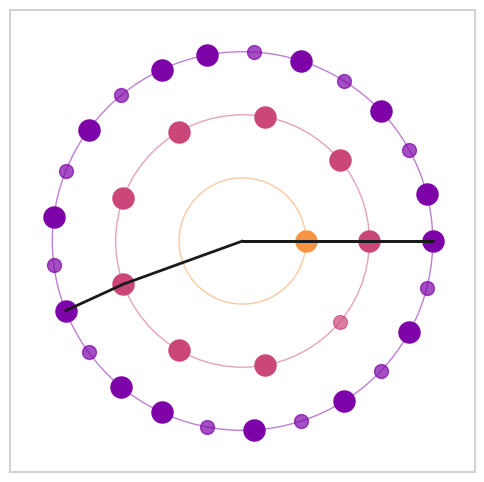

In [15]:
from biotuner.biotuner_object import *


max_denoms = [6, 8, 16]
# create signal with harmonics 10, 20 and 30 Hz
time = np.linspace(0, 1, 800)
signal = np.sum([1 * np.sin(2 * np.pi * freq * time) for freq in [10, 13.33, 15, 20, 26.66, 30, 40]], axis=0)
# add noise
signal += np.random.normal(0, 0.5, len(time))
for max_denom in max_denoms:
    # Create a BioTuner object
    bt = compute_biotuner(sf=1000, peaks_function='EMD')
    bt.peaks_extraction(data=signal, precision=0.1, graph=False, min_freq=9, max_freq=41, prominence=1, identify_labels=True, n_peaks=5)
    # print the peaks
    print(bt.peaks)
    a, b, c = bt.rhythm_construction(mode='default', graph=True, scale='peaks_ratios', optimal_offsets=False, max_denom=max_denom)
    


### Figure 8. Harmonic Spectrum

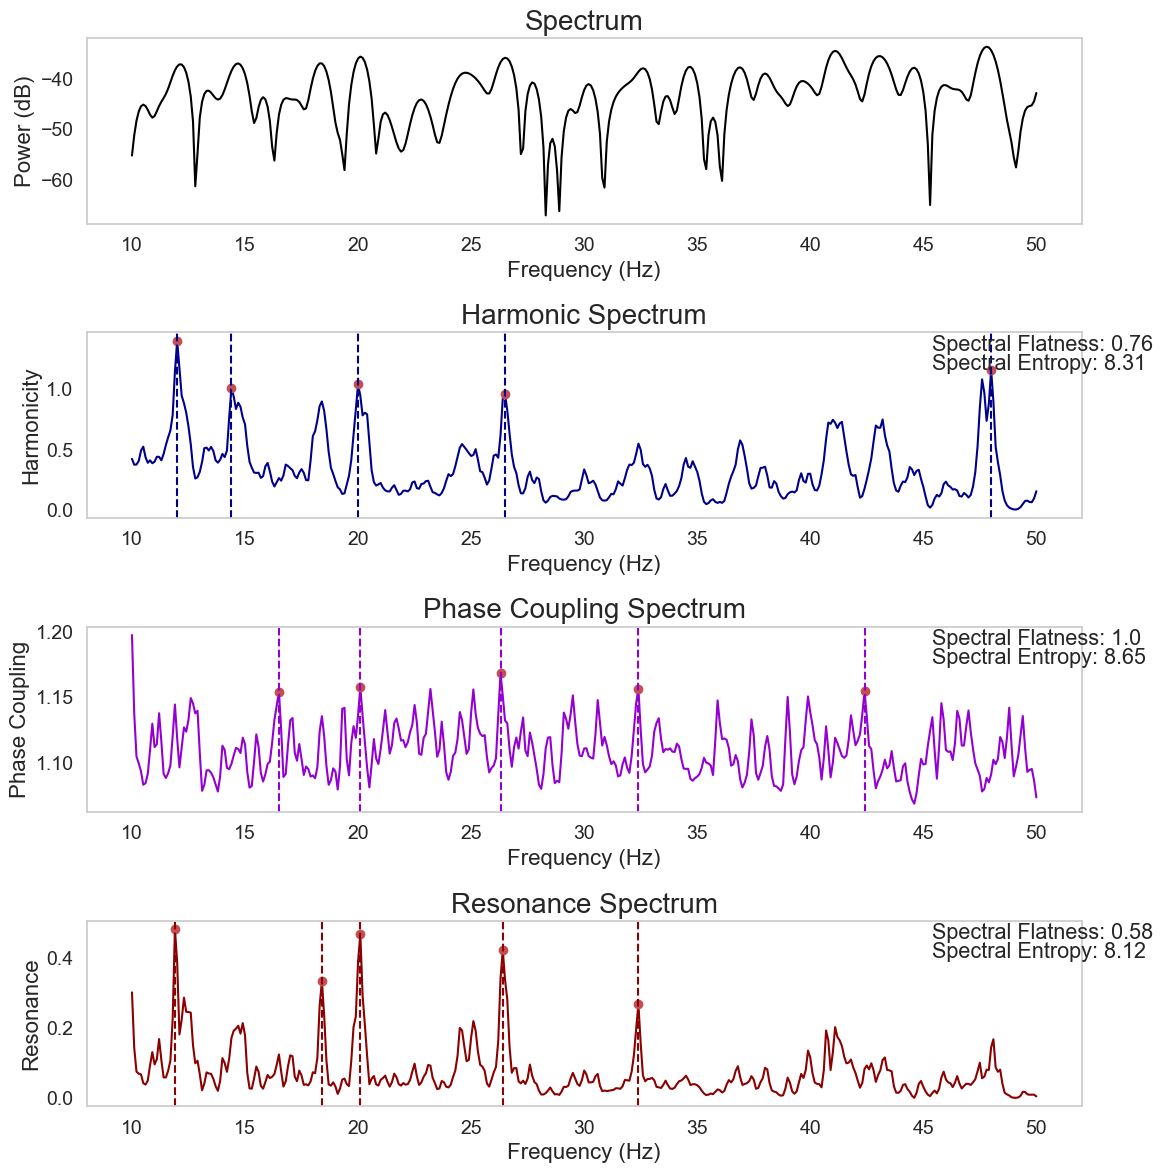

In [12]:
from biotuner.harmonic_spectrum import compute_global_harmonicity
import numpy as np

# generate a signal with peaks at 10, 20 and 30 Hz
time = np.linspace(0, 1, 2000)
signal = np.sum([1 * np.sin(2 * np.pi * freq * time) for freq in [10, 20, 30]], axis=0)
# add 10% of noise
signal += np.random.normal(0, 0.2, len(time))

# generate a white noise signal
pink_noise = np.random.normal(0, 0.2, len(time))

harm_spectrum_df = compute_global_harmonicity(pink_noise, 0.1, 10, 50, fs=1000,
                                             noverlap=1, power_law_remove=True, n_peaks=5, plot=True,
                                             smoothness=1, metric='harmsim', delta_lim=500, smoothness_harm=1, 
                                             n_harms=5, phase_mode=None)